In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns

import matplotlib.ticker as ticker

plt.rcParams['font.family'] = 'Hiragino sans'


# Step1 : Data preprocessing

# wind speed data for Hornsea 1 
dwd_Hornsea1 = xr.open_dataset("dwd_icon_eu_hornsea_1_20200920_20231027.nc")
dwd_Hornsea1_features = dwd_Hornsea1["WindSpeed:100"].mean(dim=["latitude","longitude"]).to_dataframe().reset_index()
dwd_Hornsea1_features["ref_datetime"] = dwd_Hornsea1_features["ref_datetime"].dt.tz_localize("UTC")
dwd_Hornsea1_features["valid_datetime"] = dwd_Hornsea1_features["ref_datetime"] + pd.TimedeltaIndex(dwd_Hornsea1_features["valid_datetime"],unit="hours")

# solar radiation data for East England PV
dwd_solar = xr.open_dataset("dwd_icon_eu_pes10_20200920_20231027.nc")
dwd_solar_features = dwd_solar["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
dwd_solar_features["ref_datetime"] = dwd_solar_features["ref_datetime"].dt.tz_localize("UTC")
dwd_solar_features["valid_datetime"] = dwd_solar_features["ref_datetime"] + pd.TimedeltaIndex(dwd_solar_features["valid_datetime"],unit="hours")

# Read energy data from a CSV file
energy_data = pd.read_csv("Energy_Data_20200920_20231027.csv")
energy_data["dtm"] = pd.to_datetime(energy_data["dtm"])
energy_data["Wind_MWh_credit"] = 0.5*energy_data["Wind_MW"] - energy_data["boa_MWh"]
energy_data["Solar_MWh_credit"] = 0.5*energy_data["Solar_MW"]

# Merge all date and filter data
modelling_table = dwd_Hornsea1_features.merge(dwd_solar_features,how="outer",on=["ref_datetime","valid_datetime"])
modelling_table = modelling_table.set_index("valid_datetime").groupby("ref_datetime").resample("30T").interpolate("linear")
modelling_table = modelling_table.drop(columns="ref_datetime",axis=1).reset_index()
modelling_table = modelling_table.merge(energy_data,how="inner",left_on="valid_datetime",right_on="dtm")
modelling_table = modelling_table[modelling_table["valid_datetime"] - modelling_table["ref_datetime"] <= np.timedelta64(48,"h")]
modelling_table.rename(columns={"WindSpeed:100":"WindSpeed"},inplace=True)



# Step2 : Analysis 

# Remove rows with missing values in solar radiation and wind speed
modelling_table = modelling_table[modelling_table["SolarDownwardRadiation"].notnull()]
modelling_table = modelling_table[modelling_table["WindSpeed"].notnull()]

# Create total generation and use quantile regression
modelling_table["total_generation_MWh"] = modelling_table["Wind_MWh_credit"] + modelling_table["Solar_MWh_credit"]
mod = smf.quantreg('total_generation_MWh ~ bs(SolarDownwardRadiation,df=5) + bs(WindSpeed,df=8)', data=modelling_table)

# Fit quantile regression models for different quantiles
forecast_models = dict()
for quantile in range(10,100,10):
    forecast_models[f"q{quantile}"] = mod.fit(q=quantile/100,max_iter=2500)
    modelling_table[f"q{quantile}"] = forecast_models[f"q{quantile}"].predict(modelling_table)
    modelling_table.loc[modelling_table[f"q{quantile}"] < 0, f"q{quantile}"] = 0
 
# Save the quantile regression models to files   
for quantile in range(10,100,10):
    forecast_models[f"q{quantile}"].save(f"models/model_q{quantile}.pickle")
    

# Step3 : Evaluation

# Define the Pinball function
def pinball(y,q,alpha):
    return (y-q)*alpha*(y>=q) + (q-y)*(1-alpha)*(y<q)

# Calculate the Pinball Score
def pinball_score(df):
    score = list()
    for qu in range(10,100,10):
        score.append(pinball(y=df["total_generation_MWh"], q=df[f"q{qu}"], alpha=qu/100).mean())
    return sum(score)/len(score)

pinball_score(modelling_table)

/usr/local/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (2500) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


29.189772900643206

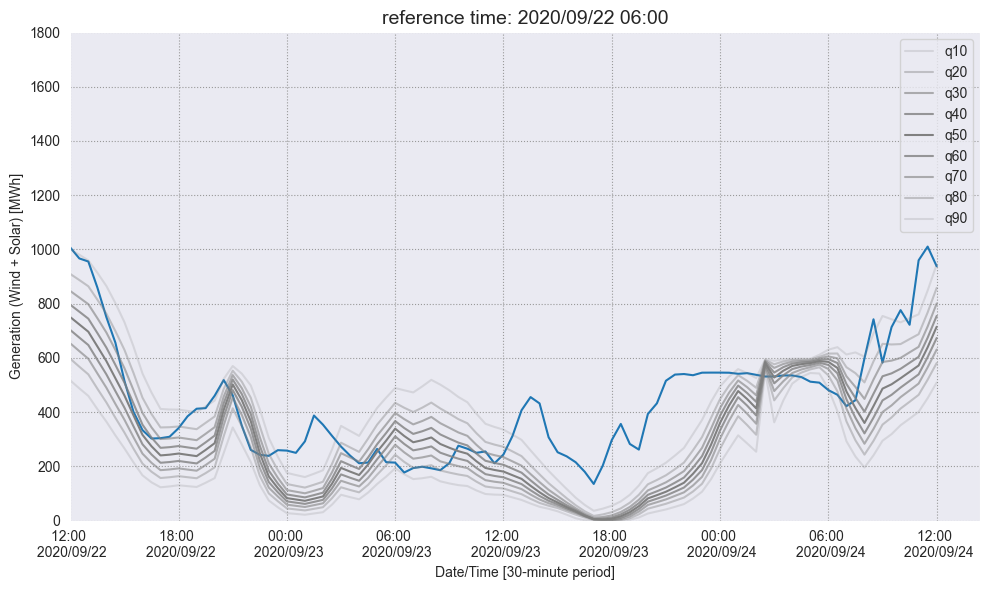

In [17]:
ref_time = modelling_table["ref_datetime"] == modelling_table["ref_datetime"][802]

plt.figure(figsize=(10,6))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
ax1 = sns.lineplot(data=modelling_table[ref_time], x="valid_datetime",
                   y="total_generation_MWh")

for quantile in range(10,100,10):
    sns.lineplot(data=modelling_table,
                 x=modelling_table[ref_time]["valid_datetime"],
                 y=modelling_table[ref_time][f"q{quantile}"],
                 color='gray',
                 alpha=1-abs(50-quantile)/50,
                 label=f'q{quantile}')

plt.ylim(0, 1800)
plt.xlim(modelling_table[ref_time]['valid_datetime'].min())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M \n %Y/%m/%d"))
plt.xlabel('Date/Time [30-minute period]')
plt.ylabel('Generation (Wind + Solar) [MWh]')
plt.title(f"reference time: {modelling_table['ref_datetime'][801].strftime('%Y/%m/%d %H:%M')}",
          fontsize=14)
plt.tight_layout()

In [5]:
def pinball(y,q,alpha):
    return (y-q)*alpha*(y>=q) + (q-y)*(1-alpha)*(y<q)

def pinball_score(df):
    score = list()
    for qu in range(10,100,10):
        score.append(pinball(y=df["total_generation_MWh"], q=df[f"q{qu}"], alpha=qu/100).mean())
    return sum(score)/len(score)

pinball_score(modelling_table)

29.189772900643206

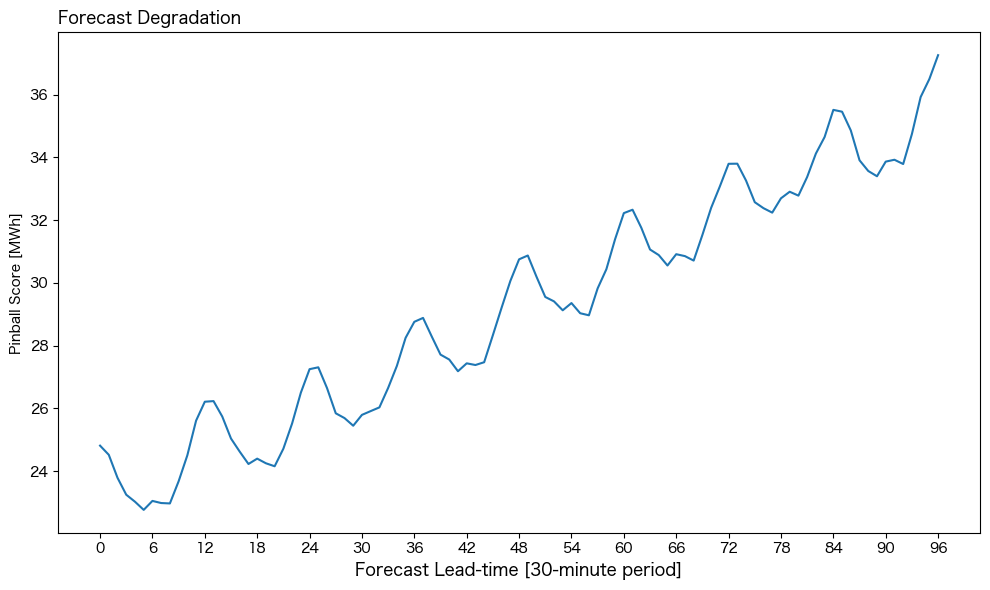

In [8]:
import matplotlib.ticker as ticker

modelling_table['lead_time'] = modelling_table['valid_datetime'] - modelling_table['ref_datetime']

forecast_performance = modelling_table.groupby('lead_time').apply(pinball_score)
forecast_performance = modelling_table.groupby('lead_time').apply(pinball_score)
forecast_performance.index = forecast_performance.index.total_seconds() / (1800)

plt.figure(figsize=(10, 6))
ax1 = forecast_performance.plot()
ax1.set_ylabel('Pinball Score [MWh]')
ax1.set_xlabel('Forecast Lead-time [30-minute period]', fontsize=12)

# x軸の刻みを変更
ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=6))  # 6は3時間ごとに調整したい場合

ax1.set_title('Forecast Degradation', loc='left')
plt.tight_layout()

In [14]:
# Define the Pinball function
def pinball(y, q, alpha):
    return (y - q) * alpha * (y >= q) + (q - y) * (1 - alpha) * (y < q)

def pinball_score(df):
    scores = []
    quantile_scores = {}
    
    for qu in range(10, 100, 10):
        pinball_values = pinball(y=df["total_generation_MWh"], q=df[f"q{qu}"], alpha=qu/100)
        scores.append(pinball_values.mean())
        
        # Store the score for each quantile
        quantile_scores[f"Quantile {qu}"] = pinball_values.mean()

    avg_score = sum(scores) / len(scores)
    print(f"Average Scores: {quantile_scores}")
    print(f"Overall Average Score: {avg_score}")

    return quantile_scores, avg_score

quantile_scores, average_score = pinball_score(modelling_table)


Average Scores: {'Quantile 10': 17.618267636965847, 'Quantile 20': 26.707470076919584, 'Quantile 30': 32.47147617320642, 'Quantile 40': 35.751367941182494, 'Quantile 50': 36.86565693653562, 'Quantile 60': 35.88493276660411, 'Quantile 70': 32.70575285078577, 'Quantile 80': 26.973254773753354, 'Quantile 90': 17.729776949835696}
Overall Average Score: 29.189772900643206


In [16]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

# 評価関数を追加
def evaluate_forecast(df):
    # q50 と total_generation_MWh を比較
    forecast_q50 = df["q50"]
    actual_generation = df["total_generation_MWh"]

    # RMSE（Root Mean Squared Error）を計算
    rmse = np.sqrt(mean_squared_error(actual_generation, forecast_q50))

    # MSE（Mean Squared Error）を計算
    mse = mean_squared_error(actual_generation, forecast_q50)

    print(f"RMSE: {rmse}")
    print(f"MSE: {mse}")

    return rmse, mse

modelling_table = modelling_table.fillna(modelling_table.mean())

# モデル評価
evaluate_forecast(modelling_table)

RMSE: 110.8216416159249
MSE: 12281.436250448498


(110.8216416159249, 12281.436250448498)